In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import các thư viện cần
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy

#Nạp dữ liệu

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')

In [4]:
train111 = copy.deepcopy(train)

In [5]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
test

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [7]:
sample_submission

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52
...,...,...
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52


# Nối tập test và train thành 1 tập là two_df

In [8]:
two_df = pd.concat([train, test], sort=False)

In [9]:
two_df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


#0 -> 912999(của tập train), sau đó 0 -> 44999(của tập test)  => ta có 958000 dòng và 5 cột

In [10]:
two_df.shape

(958000, 5)

# Tách cột date cụ thể hơn => thêm vào các cột mới

In [11]:
two_df.dtypes

date      object
store      int64
item       int64
sales    float64
id       float64
dtype: object

In [12]:
def date_features(df):
  df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True) #chuyển đổi thành kiểu datetime
  df['year'] = df['date'].dt.year #năm
  df['month'] = df['date'].dt.month# tháng
  df['day'] = df['date'].dt.dayofweek #ngày của tuần
  df['quarter'] = df['date'].dt.quarter #tuần trong tháng
  df['weekofyear'] = df['date'].dt.weekofyear #tuần của năm

  return df


#Biểu diễn 1 số biểu đồ

In [13]:
date_features(train111)
train111

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


,date,store,item,sales,year,month,day,quarter,weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1
1,2013-01-02,1,1,11,2013,1,2,1,1
2,2013-01-03,1,1,14,2013,1,3,1,1
3,2013-01-04,1,1,13,2013,1,4,1,1
4,2013-01-05,1,1,10,2013,1,5,1,1
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12,2,4,52
912996,2017-12-28,10,50,59,2017,12,3,4,52
912997,2017-12-29,10,50,74,2017,12,4,4,52
912998,2017-12-30,10,50,62,2017,12,5,4,52


# Tổng doanh thu(sales) của 10 store từ năm 2013 đến cuối năm 2017 trong tập train

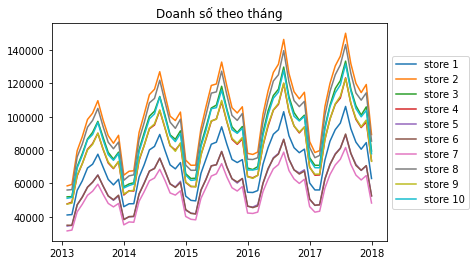

In [14]:
for i in range(1,11): # 12 tháng
    month_df = train111[train111.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index) # trục hoành biểu thị cho các tháng
    y= np.array(month_df.sales) # trục tung thể hiện sales( doanh thu )
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Doanh số theo tháng")
plt.show()

# Heatmap: Biểu diễn sales của từng store với từng item trong 5 năm của tập train.

Text(0.5, 1.0, 'Store/ Item sales heatmap')

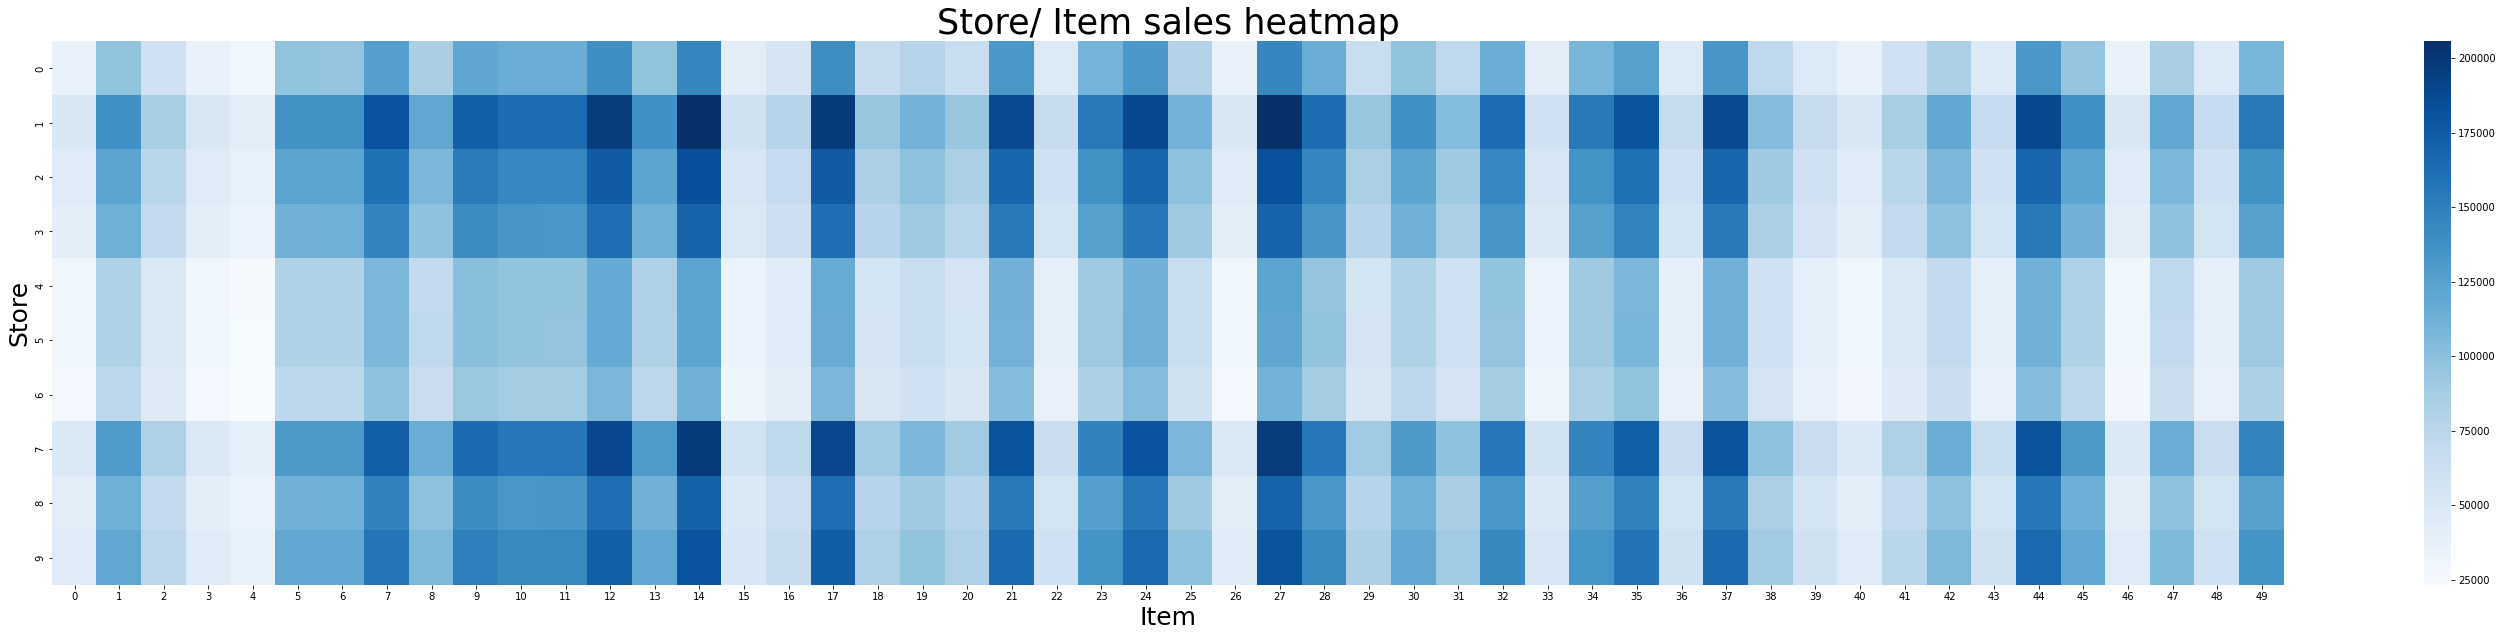

In [15]:
#gom nhóm theo store cà item và tính tổng cho sales
store_item_c = train111.groupby(['store','item'])['sales'].sum()
matrixStoreItem = np.zeros((10,50))
for i in range(1,11):
    for j in range(1,51):
        matrixStoreItem[i-1,j-1] = store_item_c.loc[i,j]

plt.figure(figsize=(50,10))
ax = sns.heatmap(matrixStoreItem,cmap='Blues')
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Store",fontsize=25)
plt.title("Store/ Item sales heatmap",fontsize=35)

In [16]:
# đối với từng cửa hàng sales của từng item trong cửa hàng đó.
print(store_item_c)

store  item
1      1        36468
       2        97050
       3        60638
       4        36440
       5        30335
                ...  
10     46      120601
       47       45204
       48      105570
       49       60317
       50      135192
Name: sales, Length: 500, dtype: int64


# Trung bình doanh thu của các items

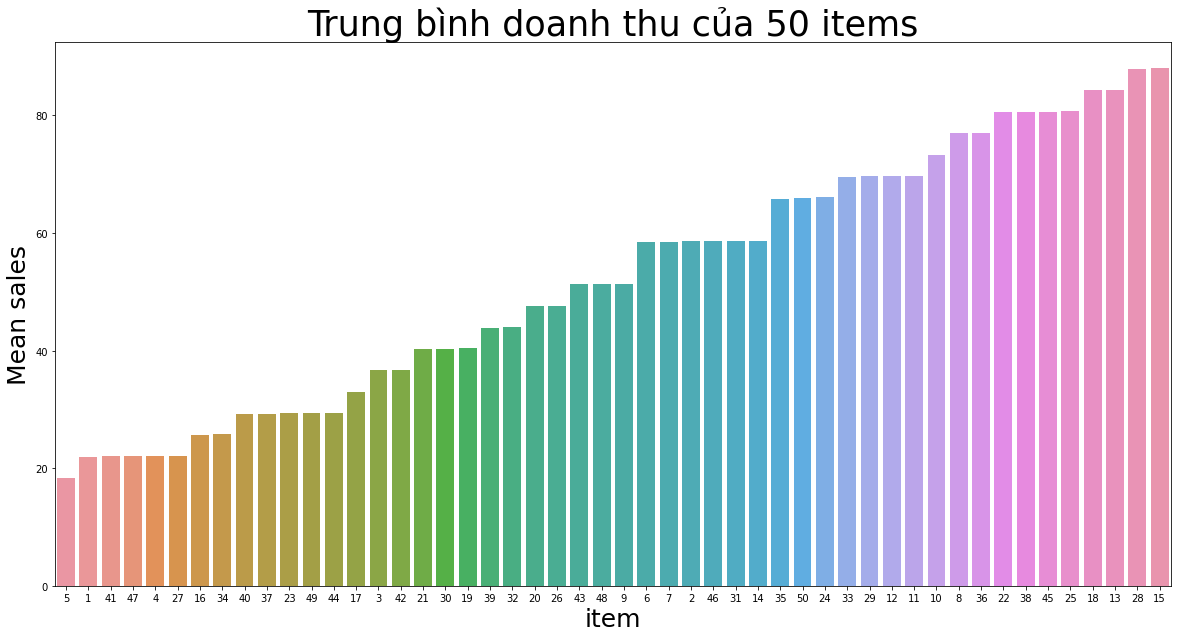

In [17]:
plt.close('all')
item_df = train111.groupby(['item']).mean()
item_df.sort_values('sales',ascending=True,inplace=True)
x = item_df.index
y = item_df.sales
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y, order=x)
plt.xlabel("item",fontsize = 25)
plt.ylabel("Mean sales",fontsize=25)
plt.title("Trung bình doanh thu của 50 items",fontsize=35)
plt.show()

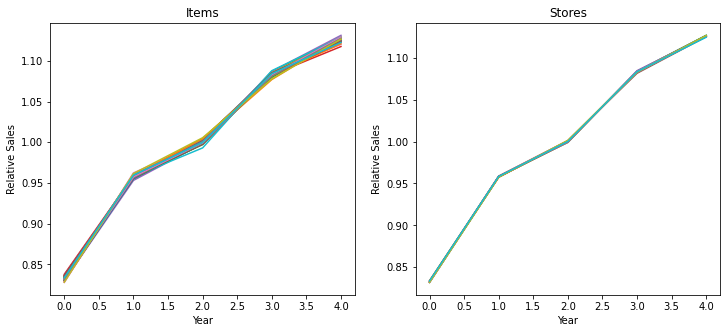

In [18]:
agg_year_item = pd.pivot_table(train111, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train111, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()

# Qua 2 biểu đồ trên: cho thấy các item và store dường như đều có mức tăng trưởng doanh thu tương tự nhau (sales) trong những năm của tập train.

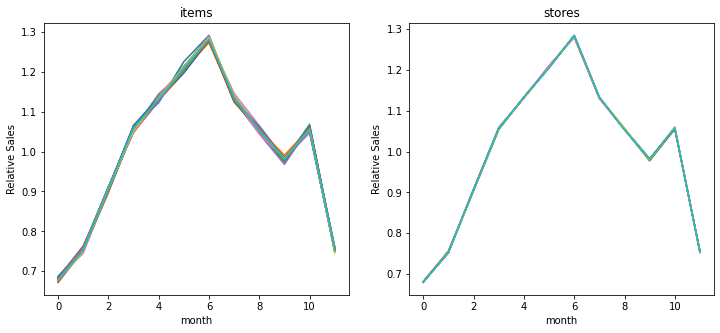

In [19]:
#tương tự với tháng
agg_month_item = pd.pivot_table(train111, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train111, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("items")
plt.xlabel("month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("stores")
plt.xlabel("month")
plt.ylabel("Relative Sales")
plt.show()


# Biểu đồ theo tháng ở trên cũng có mô hình tăng tăng trưởng doanh thu tương tự nhau của stores và items

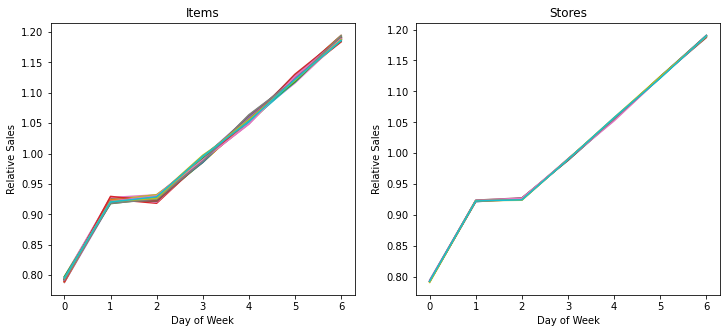

In [20]:
train111['dayofweek'] = train111.date.dt.dayofweek # ngày của tuần
agg_dow_item = pd.pivot_table(train111, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(train111, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

# 2 biểu đồ trên cũng cho thấy tăng trưởng theo day of week cũng tương tự nhau

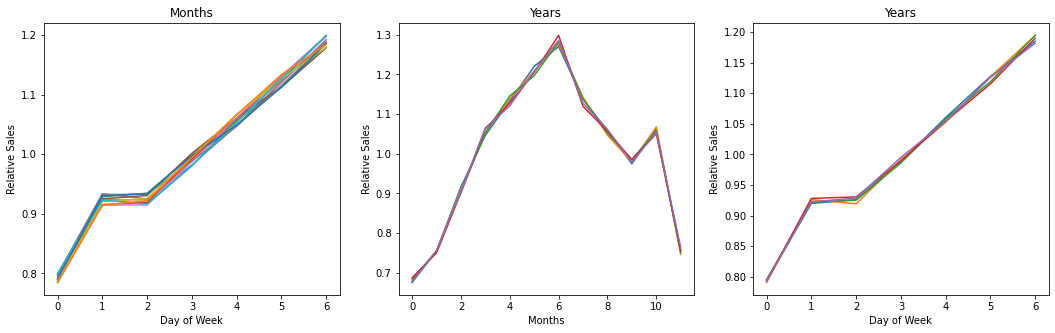

In [21]:
agg_dayofweek_month = pd.pivot_table(train111, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(train111, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dayofweek_year = pd.pivot_table(train111, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dayofweek_month / agg_dayofweek_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dayofweek_year / agg_dayofweek_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

# Ba biểu đồ trên cho thấy cuối tuần của tháng và năm: doanh số có tăng lên nhiều, doanh thu đạt đỉnh có vẻ vào khoảng tháng 7

In [22]:
#=========================================

In [23]:
# add columns: date related
two_df['date'] = pd.to_datetime(two_df['date'],infer_datetime_format=True) #chuyển đổi thành kiểu datetime
two_df['year'] = two_df['date'].dt.year #năm
two_df['month'] = two_df['date'].dt.month# tháng
two_df['day'] = two_df['date'].dt.dayofweek #ngày của tuần
two_df['quarter'] = two_df['date'].dt.quarter
two_df['weekofyear'] = two_df['date'].dt.weekofyear #tuần của năm


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


In [24]:
#xóa bỏ cột date sau khi xử lý xog
two_df.drop('date', axis=1, inplace=True)

# Thêm các cột được tách của tập two_df vào tập train

In [25]:
train=pd.DataFrame(two_df[two_df.sales.notna()].values) #lấy giá trị của các phần tử
train.columns=two_df.columns

In [26]:
train

,store,item,sales,id,year,month,day,quarter,weekofyear
0,1.0,1.0,13.0,NaN,2013.0,1.0,1.0,1.0,1.0
1,1.0,1.0,11.0,NaN,2013.0,1.0,2.0,1.0,1.0
2,1.0,1.0,14.0,NaN,2013.0,1.0,3.0,1.0,1.0
3,1.0,1.0,13.0,NaN,2013.0,1.0,4.0,1.0,1.0
4,1.0,1.0,10.0,NaN,2013.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
912995,10.0,50.0,63.0,NaN,2017.0,12.0,2.0,4.0,52.0
912996,10.0,50.0,59.0,NaN,2017.0,12.0,3.0,4.0,52.0
912997,10.0,50.0,74.0,NaN,2017.0,12.0,4.0,4.0,52.0
912998,10.0,50.0,62.0,NaN,2017.0,12.0,5.0,4.0,52.0


In [27]:
#kiểm tra NaN
train_nan= train.isna()
train_sum_nan = train_nan.sum()
train_sum_nan

store              0
item               0
sales              0
id            913000
year               0
month              0
day                0
quarter            0
weekofyear         0
dtype: int64

#Thêm 1 cột target = cột sales

In [28]:
train['target']=train['sales'] 

In [29]:
train

,store,item,sales,id,year,month,day,quarter,weekofyear,target
0,1.0,1.0,13.0,NaN,2013.0,1.0,1.0,1.0,1.0,13.0
1,1.0,1.0,11.0,NaN,2013.0,1.0,2.0,1.0,1.0,11.0
2,1.0,1.0,14.0,NaN,2013.0,1.0,3.0,1.0,1.0,14.0
3,1.0,1.0,13.0,NaN,2013.0,1.0,4.0,1.0,1.0,13.0
4,1.0,1.0,10.0,NaN,2013.0,1.0,5.0,1.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...
912995,10.0,50.0,63.0,NaN,2017.0,12.0,2.0,4.0,52.0,63.0
912996,10.0,50.0,59.0,NaN,2017.0,12.0,3.0,4.0,52.0,59.0
912997,10.0,50.0,74.0,NaN,2017.0,12.0,4.0,4.0,52.0,74.0
912998,10.0,50.0,62.0,NaN,2017.0,12.0,5.0,4.0,52.0,62.0


# Hàm add_agg

In [30]:
def add_agg(two_df, group_cols, newcol_name, year):
    cols2 = group_cols.copy() 
    cols2.append(newcol_name) #thêm newcol_name vào cols2
    #gom nhóm theo 3 cột item+store+year của tập train và tính trung bình cho cột target
    agg1 = train.groupby(group_cols)['target'].agg('mean').reset_index()
    #gán nhãn của các cột cols2 cho agg1
    agg1.columns = cols2
    agg1['year']+= year #năm 2014 trở đi
    #merge tương ứng các cột của two_df và agg1
    two_df = pd.merge(two_df, agg1, how='left', left_on=group_cols, right_on=group_cols)
    return two_df

#scale cho item+store+year.

In [31]:
two_df = add_agg(two_df,['item','store','year'], 'tsy', 1)

In [32]:
two_df

,store,item,sales,id,year,month,day,quarter,weekofyear,tsy
0,1,1,13.0,NaN,2013,1,1,1,1,NaN
1,1,1,11.0,NaN,2013,1,2,1,1,NaN
2,1,1,14.0,NaN,2013,1,3,1,1,NaN
3,1,1,13.0,NaN,2013,1,4,1,1,NaN
4,1,1,10.0,NaN,2013,1,5,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
957995,10,50,NaN,44995.0,2018,3,1,1,13,82.90411
957996,10,50,NaN,44996.0,2018,3,2,1,13,82.90411
957997,10,50,NaN,44997.0,2018,3,3,1,13,82.90411
957998,10,50,NaN,44998.0,2018,3,4,1,13,82.90411


In [33]:
two_df['sales']/=two_df['tsy']

In [34]:
two_df

,store,item,sales,id,year,month,day,quarter,weekofyear,tsy
0,1,1,NaN,NaN,2013,1,1,1,1,NaN
1,1,1,NaN,NaN,2013,1,2,1,1,NaN
2,1,1,NaN,NaN,2013,1,3,1,1,NaN
3,1,1,NaN,NaN,2013,1,4,1,1,NaN
4,1,1,NaN,NaN,2013,1,5,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
957995,10,50,NaN,44995.0,2018,3,1,1,13,82.90411
957996,10,50,NaN,44996.0,2018,3,2,1,13,82.90411
957997,10,50,NaN,44997.0,2018,3,3,1,13,82.90411
957998,10,50,NaN,44998.0,2018,3,4,1,13,82.90411


In [35]:
#kiểm tra NaN
two_df_nan= two_df.isna()
two_df_sum_nan = two_df_nan.sum()
two_df_sum_nan

store              0
item               0
sales         227500
id            913000
year               0
month              0
day                0
quarter            0
weekofyear         0
tsy           182500
dtype: int64

#Sau năm 2013

In [36]:
two_df = two_df[two_df.year>2013]

In [37]:
two_df

,store,item,sales,id,year,month,day,quarter,weekofyear,tsy
365,1,1,0.545228,NaN,2014,1,2,1,1,16.506849
366,1,1,0.848133,NaN,2014,1,3,1,1,16.506849
367,1,1,0.666390,NaN,2014,1,4,1,1,16.506849
368,1,1,1.211618,NaN,2014,1,5,1,1,16.506849
369,1,1,1.029876,NaN,2014,1,6,1,1,16.506849
...,...,...,...,...,...,...,...,...,...,...
957995,10,50,NaN,44995.0,2018,3,1,1,13,82.904110
957996,10,50,NaN,44996.0,2018,3,2,1,13,82.904110
957997,10,50,NaN,44997.0,2018,3,3,1,13,82.904110
957998,10,50,NaN,44998.0,2018,3,4,1,13,82.904110


In [38]:
#kiểm tra NaN
two_df_nan= two_df.isna()
two_df_sum_nan = two_df_nan.sum()
two_df_sum_nan

store              0
item               0
sales          45000
id            730500
year               0
month              0
day                0
quarter            0
weekofyear         0
tsy                0
dtype: int64

#Pop lấy tsy trong two_df

In [39]:
tsy=two_df.pop('tsy')

In [40]:
tsy

365       16.506849
366       16.506849
367       16.506849
368       16.506849
369       16.506849
            ...    
957995    82.904110
957996    82.904110
957997    82.904110
957998    82.904110
957999    82.904110
Name: tsy, Length: 775500, dtype: float64

#two_df còn lại

In [41]:
two_df

,store,item,sales,id,year,month,day,quarter,weekofyear
365,1,1,0.545228,NaN,2014,1,2,1,1
366,1,1,0.848133,NaN,2014,1,3,1,1
367,1,1,0.666390,NaN,2014,1,4,1,1
368,1,1,1.211618,NaN,2014,1,5,1,1
369,1,1,1.029876,NaN,2014,1,6,1,1
...,...,...,...,...,...,...,...,...,...
957995,10,50,NaN,44995.0,2018,3,1,1,13
957996,10,50,NaN,44996.0,2018,3,2,1,13
957997,10,50,NaN,44997.0,2018,3,3,1,13
957998,10,50,NaN,44998.0,2018,3,4,1,13


#Pop cột sales và id

In [42]:
Id=two_df[two_df.id.notna()]['id']
target = two_df[two_df.sales.notna()]['sales']
two_df.drop('id', axis=1, inplace=True)
two_df.drop('sales', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [43]:
target

365       0.545228
366       0.848133
367       0.666390
368       1.211618
369       1.029876
            ...   
912995    0.782901
912996    0.733193
912997    0.919598
912998    0.770474
912999    1.019014
Name: sales, Length: 730500, dtype: float64

In [44]:
two_df

,store,item,year,month,day,quarter,weekofyear
365,1,1,2014,1,2,1,1
366,1,1,2014,1,3,1,1
367,1,1,2014,1,4,1,1
368,1,1,2014,1,5,1,1
369,1,1,2014,1,6,1,1
...,...,...,...,...,...,...,...
957995,10,50,2018,3,1,1,13
957996,10,50,2018,3,2,1,13
957997,10,50,2018,3,3,1,13
957998,10,50,2018,3,4,1,13


#1.LGBM (Tốt nhất) cho điểm cao nhất

#Set parameters cho mô hình LGBM

In [45]:
params = {
    'nthread': 10, #số luồng cho LGBM
    'max_depth': 6, #giới hạn độ sâu cho tree model
    'task': 'train', #train
    'boosting_type': 'gbdt', #Cây quyết định tăng cường Gradient truyền thống
    'objective': 'regression_l1',
    'metric': 'mape', #abs(a-e)/max(1,a) #chỉ số đánh giá: sai số trung bình tuyệt đối
    'num_leaves': 31, #số lá tối đa của 1 cây
    'learning_rate': 0.25,
    'feature_fraction': 0.9, #LGBM sẽ chọn 80% feature trước khi training
    'bagging_fraction': 0.8, # tương tự như feature_fraction nhưng không cần lấy mẫu lại
    'bagging_freq': 5, #tần suất bao đóng
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1 #mức độ chi tiết của mô hình LGBM
}

#Lấy tương đương tập test và train cho x_test và y_all

In [46]:
train_length = len(target)
x_test = two_df[train_length:].values #lấy tương đương tập test

In [47]:
len(x_test)

45000

In [48]:
x_all = two_df[:train_length].values #lấy tương đương tập train
y_all = target.values

In [49]:
len(y_all)

730500

#Tạo mảng mới toàn số 0 với số phần tử = với len(y_all) và len(x_test)

In [50]:
a = np.zeros(len(y_all))
b = np.zeros(len(x_test))

In [51]:
a

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
b

array([0., 0., 0., ..., 0., 0., 0.])

#Sử dụng phương pháp K-Fold

In [53]:
#chia tập thành 5 fold, có xáo trộn(shuffle)
folds = KFold(n_splits=5, shuffle=True, random_state=345665)

for n_fold, (train_index, valid_index) in enumerate(folds.split(x_all)):
    #tập x_train tương đương với tập x_all
    #nhãn y_train sẽ tương tương với nhãn x_all
    print(train_index)
    print(valid_index)
    x_train, y_train = x_all[train_index], y_all[train_index]
    #tập dữ liệu xác thực
    valid_x, valid_y = x_all[valid_index], y_all[valid_index]
    #tải dữ liệu vào dataset
    lgb_train = lgb.Dataset(x_train,y_train)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
    #training
    gbm = lgb.train(params, lgb_train, 1000, 
        valid_sets=[lgb_train, lgb_valid], #truyền vào tập dữ liệu xác thực để dừng sớm
        early_stopping_rounds=200, verbose_eval=100) 
    a[valid_index] = gbm.predict(valid_x, num_iteration=gbm.best_iteration) #nhận dự đoán từ lần lặp tốt nhất
    b[:] += gbm.predict(x_test, num_iteration=gbm.best_iteration) / folds.n_splits
    valid_index += 1

[     0      3      4 ... 730496 730498 730499]
[     1      2      8 ... 730491 730493 730497]
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.109131	valid_1's mape: 0.109651
[200]	training's mape: 0.108827	valid_1's mape: 0.109715
Early stopping, best iteration is:
[33]	training's mape: 0.10944	valid_1's mape: 0.109609
[     0      1      2 ... 730496 730497 730498]
[     5     11     27 ... 730479 730495 730499]
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.109136	valid_1's mape: 0.109764
[200]	training's mape: 0.108816	valid_1's mape: 0.109834
Early stopping, best iteration is:
[59]	training's mape: 0.109297	valid_1's mape: 0.109709
[     0      1      2 ... 730496 730497 730499]
[     9     15     18 ... 730490 730492 730498]
Training until validation scores don't improve for 200 rounds.
[100]	training's mape: 0.109147	valid_1's mape: 0.109665
[200]	training's mape: 0.108853	valid_1's mape: 0.109735


#2.XGB cho score thấp hơn LGBM

#Cũng sử dụng K Fold

In [54]:
'''#chia tập thành 5 fold, có xáo trộn(shuffle)
folds = KFold(n_splits=5, shuffle=True, random_state=345665)

for n_fold, (train_index, valid_index) in enumerate(folds.split(x_all)):
    #tập x_train tương đương với tập x_all
    #nhãn y_train sẽ tương tương với nhãn x_all
    print(train_index)
    print(valid_index)
    x_train, y_train = x_all[train_index], y_all[train_index]
    #tập dữ liệu xác thực
    valid_x, valid_y = x_all[valid_index], y_all[valid_index]
    #tải dữ liệu vào dataset
    lgb_train = lgb.Dataset(x_train,y_train)
    lgb_valid = lgb.Dataset(valid_x,valid_y)
    #training
    matrix_train = xgb.DMatrix(x_train, label = y_train)
    matrix_test = xgb.DMatrix(valid_x, label = valid_y)

    # Run XGB 
    model = xgb.train(params={'objective':'reg:linear','eval_metric':'mae'}
                ,dtrain = matrix_train, num_boost_round = 500, 
                early_stopping_rounds = 20, evals = [(matrix_test,'test')],)
    a[valid_index] = model.predict(xgb.DMatrix(valid_x), ntree_limit = model.best_ntree_limit) #nhận dự đoán từ lần lặp tốt nhất
    b[:] += model.predict(xgb.DMatrix(x_test), ntree_limit = model.best_ntree_limit) / folds.n_splits
    valid_index += 1'''

"#chia tập thành 5 fold, có xáo trộn(shuffle)\nfolds = KFold(n_splits=5, shuffle=True, random_state=345665)\n\nfor n_fold, (train_index, valid_index) in enumerate(folds.split(x_all)):\n    #tập x_train tương đương với tập x_all\n    #nhãn y_train sẽ tương tương với nhãn x_all\n    print(train_index)\n    print(valid_index)\n    x_train, y_train = x_all[train_index], y_all[train_index]\n    #tập dữ liệu xác thực\n    valid_x, valid_y = x_all[valid_index], y_all[valid_index]\n    #tải dữ liệu vào dataset\n    lgb_train = lgb.Dataset(x_train,y_train)\n    lgb_valid = lgb.Dataset(valid_x,valid_y)\n    #training\n    matrix_train = xgb.DMatrix(x_train, label = y_train)\n    matrix_test = xgb.DMatrix(valid_x, label = valid_y)\n\n    # Run XGB \n    model = xgb.train(params={'objective':'reg:linear','eval_metric':'mae'}\n                ,dtrain = matrix_train, num_boost_round = 500, \n                early_stopping_rounds = 20, evals = [(matrix_test,'test')],)\n    a[valid_index] = model.pred

In [55]:
a.shape

(730500,)

In [56]:
a[valid_index]

array([0.91209391, 0.60892947, 0.71476682, ..., 0.71111124, 0.82023659,
       0.74436601])

In [57]:
b

array([0.56267642, 0.64569196, 0.64867986, ..., 0.91850775, 0.97872026,
       1.04417661])

In [58]:
b[:]

array([0.56267642, 0.64569196, 0.64867986, ..., 0.91850775, 0.97872026,
       1.04417661])

#Dự đoán

In [59]:
pred = (b * tsy[train_length:] ).astype(np.float32)

In [60]:
tsy[train_length:]

913000    22.183562
913001    22.183562
913002    22.183562
913003    22.183562
913004    22.183562
            ...    
957995    82.904110
957996    82.904110
957997    82.904110
957998    82.904110
957999    82.904110
Name: tsy, Length: 45000, dtype: float64

In [61]:
pred

913000    12.482167
913001    14.323748
913002    14.390030
913003    15.364563
913004    16.320196
            ...    
957995    71.475647
957996    71.674728
957997    76.148064
957998    81.139931
957999    86.566528
Name: tsy, Length: 45000, dtype: float32

#File submission

In [62]:
submission = pd.DataFrame({'id': Id.astype(np.int32), 'sales': pred})
submission.to_csv('submission.csv', index=False)
submission.head(15)

,id,sales
913000,0,12.482167
913001,1,14.323748
913002,2,14.390030
913003,3,15.364563
913004,4,16.320196
913005,5,17.458395
913006,6,18.563917
913007,7,12.467033
913008,8,14.363509
913009,9,14.429791


In [63]:
submission.tail(15)

,id,sales
957985,44985,87.155724
957986,44986,92.285469
957987,44987,61.783615
957988,44988,71.947411
957989,44989,72.146484
957990,44990,76.751427
957991,44991,81.901154
957992,44992,87.449440
957993,44993,92.240089
957994,44994,61.326607
